In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

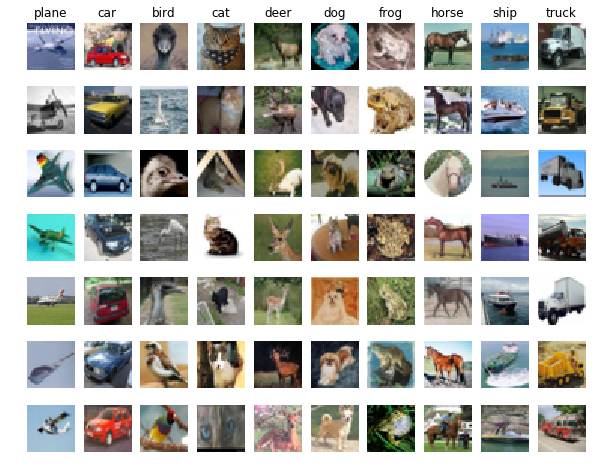

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Количество слоев заметно возросло, увеличилась точность

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Долгая обучаемость, переобучение.


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

В связи с малым количеством картинок возникнет переобучение. Надо будет использовать Shortkats, Dropout, BatchNormalization для решения этой проблемы

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

Использовать например librosa для отрисовки спектрограммы трека, а дальше работать с изображением 

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GRID K520 (0000:00:03.0)


### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [5]:
def do_residual(in_l, n):
    lay1 = lasagne.layers.Conv2DLayer(in_l, n, 3, pad='same')
    lay2 = lasagne.layers.batch_norm(lay1)
    lay3 = lasagne.layers.Conv2DLayer(lay2, n, 3, pad='same')
    lay4 = lasagne.layers.batch_norm(lay3) 
    lay5 = lasagne.layers.ElemwiseSumLayer([lay2, lay4])
    lay6 = lasagne.layers.NonlinearityLayer(lay5)
    return lay6

In [6]:
net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
input_size = 32
l1 = do_residual(net, input_size)
l2 = do_residual(l1, input_size * 2)
net = lasagne.layers.MaxPool2DLayer(l2, pool_size=2)
net = lasagne.layers.DropoutLayer(net, 0.5)
l3 = do_residual(net, input_size * 4)
net = lasagne.layers.MaxPool2DLayer(l3, pool_size=2)
l4 = do_residual(net, input_size * 8)
net = lasagne.layers.MaxPool2DLayer(l4, pool_size=2)
net = lasagne.layers.DenseLayer(net, num_units=512)
net = lasagne.layers.batch_norm(net)
net = lasagne.layers.DropoutLayer(net, 0.5)
net = lasagne.layers.DenseLayer(net, num_units=512)
net = lasagne.layers.batch_norm(net)
net = lasagne.layers.DropoutLayer(net, 0.5)
net = lasagne.layers.DenseLayer(net, num_units=10, nonlinearity=softmax)

In [7]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)

In [8]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
all_layers = lasagne.layers.get_all_layers(net)
l2_= lasagne.regularization.regularize_layer_params(all_layers, lasagne.regularization.l2) * 0.001
loss = loss + l2_

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [9]:
%%capture
updates = lasagne.updates.momentum(loss, all_weights, learning_rate=0.01, momentum = 0.9);
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True);
accuracy_fun = theano.function([input_X,target_y], accuracy, allow_input_downcast=True);

### Вот и всё, пошли её учить

In [10]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            # as in paper : 
            # pad feature arrays with 4 pixels on each side
            # and do random cropping of 32x32
            padded = np.pad(inputs[excerpt], ((0, 0), (0, 0), (4, 4), (4, 4)), mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.randint(0, 9, size=(batchsize, 2))
            for r in range(batchsize):
                random_cropped[r, :, :, :] = padded[r, :, crops[r, 0]:(crops[r, 0] + 32), crops[r, 1]:(crops[r, 1] + 32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

In [11]:
X_train = np.array(X_train, dtype = np.float32)
X_test = np.array(X_test, dtype = np.float32)
y_train = np.array(y_train, dtype = np.int32)
y_test = np.array(y_test, dtype = np.int32)

# Процесс обучения

In [13]:
import time

num_epochs = 20 #количество проходов по данным

batch_size = 25 #размер мини-батча

for epoch in range(num_epochs):

    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    

Epoch 0 of 20 took 159.170s
 training loss (in-iteration):		2.854630
 train accuracy:		42.37 %
 validation accuracy:		51.59 %
Epoch 1 of 20 took 158.910s
 training loss (in-iteration):		2.182713
 train accuracy:		58.63 %
 validation accuracy:		64.47 %
Epoch 2 of 20 took 158.071s
 training loss (in-iteration):		1.874230
 train accuracy:		66.56 %
 validation accuracy:		67.43 %
Epoch 3 of 20 took 157.938s
 training loss (in-iteration):		1.694285
 train accuracy:		70.54 %
 validation accuracy:		71.21 %
Epoch 4 of 20 took 157.104s
 training loss (in-iteration):		1.563832
 train accuracy:		72.16 %
 validation accuracy:		73.54 %
Epoch 5 of 20 took 158.703s
 training loss (in-iteration):		1.511202
 train accuracy:		75.84 %
 validation accuracy:		75.02 %
Epoch 6 of 20 took 158.046s
 training loss (in-iteration):		1.453728
 train accuracy:		77.48 %
 validation accuracy:		77.96 %
Epoch 7 of 20 took 157.413s
 training loss (in-iteration):		1.428421
 train accuracy:		78.79 %
 validation accuracy:		

In [14]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print("Achievement unlocked: колдун 80 уровня")
else:
    print("Нужно больше магии!")

Final results:
 test accuracy:		82.46 %
Нужно больше магии!
